In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 320)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format
from scipy.stats import norm
import matplotlib.pyplot as plt

In [21]:
def BlackScholes(tau, S, K, sigma):
    d1 = np.log(S/K) / sigma / np.sqrt(tau) + 0.5 * sigma * np.sqrt(tau)
    d2 = d1 - sigma * np.sqrt(tau)
    npv = (S*norm.cdf(d1) - K * norm.cdf(d2))
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(tau))
    vega = S * norm.pdf(d1) * np.sqrt(tau)
    theta = -.5 * S * norm.pdf(d1) * sigma / np.sqrt(tau)
    return {'npv': npv, 'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta}

In [15]:
class Call(object):
    def __init__(self, start, T, K, N):
        self.T = T
        self.K = K
        self.start = start  #day to sell   option
        self.N = N

    def calc(self,today,vol,S):
        if today < self.start:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':0}
        if today > self.T:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':0}
        if today == self.T:
            return {'delta':0,'npv':0,'vega':0,'gamma':0,'theta':0,'intrinsic':self.N*max(0,S-self.K)}
        tau = (self.T-today)/250.
        call = BlackScholes(tau, S, self.K, vol)
        return {'delta': self.N * call['delta'],
                'npv': self.N * call['npv'],
                'vega': self.N * call['vega'],
                'gamma': self.N * call['gamma'],
                'theta': self.N * call['theta'],
                'intrinsic': self.N * max(0, S - self.K)}


In [23]:
def deltahedge(Ndays, Sdynamics="S*=(1.0+vol*np.sqrt(dt)*np.random.randn())", volDynamics="vol=.30"):
    S = 90.0
    Strike = 100.0
    vol = .30
    columns = ('spot','vol','shares','cash','option','npv','vega','gamma','theta','pnlPredict')
    df = pd.DataFrame([[S,vol,0,0,0,0,0,0,0,0]], columns=columns)
    dt = 1/250.
    cash = 0
    dayToSellCall = 1
    maturityCall = Ndays-1
    call = Call(dayToSellCall,maturityCall,Strike,-10)# sell one call on dayToSellCall day
    for day in range(1,Ndays+1):
        exec(Sdynamics)
        exec(volDynamics)

        if day==dayToSellCall: #sell call
          callValue=call.calc(day,vol,S)
          cash-=callValue['npv']

        #delta hedge
        callValue=call.calc(day,vol,S)
        delta=callValue['delta']
        currentNumberShares=df.iloc[day-1].shares
        sharesBuy=-currentNumberShares-delta
        cash-=sharesBuy*S
        if day==maturityCall:
            cash+=call.calc(day,vol,S)['intrinsic'] #settle call

        gamma=callValue['gamma']
        theta=callValue['theta']
        dS=S-df.iloc[day-1].spot
        pnlPredict=0.5*gamma*dS*dS+theta*dt
        dfnew=pd.DataFrame([[S,vol,-delta,cash,-callValue['npv'],cash+callValue['npv']-delta*S,callValue['vega'],gamma,theta/250.,pnlPredict]],columns=columns)
        df=df.append(dfnew,ignore_index=True)

    df['pnl'] = df['npv'] - df['npv'].shift(1)
    df['vol']=100.0*df['vol']
    df['error']=df['pnl']-df['pnlPredict']
    df.set_value(dayToSellCall, "error", 0)
    #df.loc[:,['vol','spot']].plot(title='Spot and implied Volatility')
    df.loc[:,['npv','spot','option']].plot(title='-Call+delta*S+cash vs Spot {0} {1}'.format(Sdynamics,volDynamics))
    df.loc[:,['theta']].plot(title='Theta {0} {1}'.format(Sdynamics,volDynamics))
    df.loc[:,['pnl']].hist(bins=50)
    return df
    #df.loc[:,['error']].hist(bins=50)
    #print df.loc[:,['pnl']].describe()

In [39]:
df

,spot,vol,shares,cash,option,npv,vega,gamma,theta,pnlPredict,pnl,error
0,90.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
1,90.00,30.00,5.49,-317.22,177.16,0.00,-711.89,-0.07,0.11,0.11,0.00,0.00
2,90.00,30.00,5.49,-317.14,177.05,0.11,-711.55,-0.07,0.11,0.11,0.11,-0.00
3,90.00,30.00,5.49,-317.05,176.94,0.21,-711.22,-0.07,0.11,0.11,0.11,-0.00
4,90.00,30.00,5.49,-316.97,176.84,0.32,-710.88,-0.07,0.11,0.11,0.11,-0.00
5,90.00,30.00,5.49,-316.88,176.73,0.43,-710.55,-0.07,0.11,0.11,0.11,-0.00
6,90.00,30.00,5.49,-316.80,176.62,0.54,-710.21,-0.07,0.11,0.11,0.11,-0.00
7,90.00,30.00,5.49,-316.71,176.51,0.64,-709.87,-0.07,0.11,0.11,0.11,-0.00
8,90.00,30.00,5.49,-316.63,176.41,0.75,-709.54,-0.07,0.11,0.11,0.11,-0.00
9,90.00,30.00,5.49,-316.54,176.30,0.86,-709.20,-0.07,0.11,0.11,0.11,-0.00


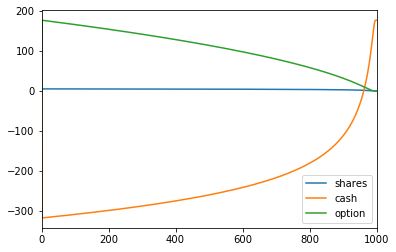

In [38]:
%matplotlib inline
df[['shares', 'cash', 'option']].plot()

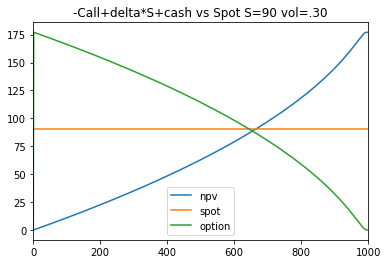

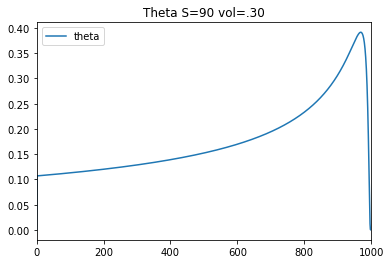

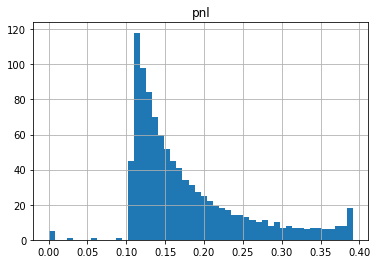

In [36]:
#df = deltahedge(1000)#constant vol
# df = deltahedge(1000, volDynamics="vol*=(1.0+0.5*np.sqrt(dt)*np.random.randn())")#stochastic vol
df = deltahedge(1000, Sdynamics="S=90") #consant OTM
# deltahedge(10000, Sdynamics="S=100") #consant ATM
# deltahedge(10000, Sdynamics="S=110")#consant ITM
# deltahedge(10000, Sdynamics="S+=S*dt") #growing stock
plt.show()
